# Image classification on Towing Tank Dataset

## Project: Write an Algorithm for the towing tank image classification task

In this notebook, I will make a further step towards developing an algorithm that could be used as part of the object detection algorithm for the project. 

## The Road Ahead

* Step 0: Load and visualisation of images
* Step 1: Loading Images using Keras Preprocessing module
* Step 2: Dataset Configuration
* Step 3: Data Augmentation and Dropout
* Step 4: Visualize treainin results after data augmentation
* Step 5: Create a CNN to Classify images (using Transfer Learning)
* Step 6: Test the Algorithm

The first step was actually the image labelling process. A dataset of 260 images was created. The dataset consists of the training and the test sets with $80\%$ (208) and $20\%$ (52) images respectively.

Since the task of the part was image classification, the individual items from the labeld images shoul be extracted. The reasult is a separate dataset with 1753 images for 5 categories, 'bolt', 'flange', 'lead_block', 'nut', 'pipe'.

In [1]:
# import libraries
import os 
import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn; sn.set(font_scale=1.4)

from sklearn.utils import shuffle
from tqdm import tqdm
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.4.1


## Limiting GPU memory growth

In this particular version of the towing image classifier, which uses the GPU of the system, there bellow error was occured during the `model.fit()` excecution. 

`
2021-01-30 11:09:45.698037: W tensorflow/core/framework/op_kernel.cc:1763] OP_REQUIRES failed at conv_ops_fused_impl.h:777 : Resource exhausted: OOM when allocating tensor with shape[32,16,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc.
`

Additionally, when the kernel initialized the model used the entire GPU memory and the following worning appeared 
`
2021-01-30 11:12:06.475107: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 5.00G (5368709120 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
`

The solution to these problems is to use [tensorflow's](https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth) virtual device configuration to limit the GPU's memory not to exceed the available memory. The same issue was reported in the [tenorflow's GitHub repo](https://github.com/tensorflow/tensorflow/issues/45068) suggest using the memory limit to avoid such issues.
For this particular version, the model worked when the memory_limit set to 3GB out of the total of 6GB memory.

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Restrict GPU memory growth 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# TODO - Fix CUDA drivers to support TF 2.4
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

1 Physical GPUs, 1 Logical GPUs
Num GPUs Available:  1


# Load and visualisation of images

In [5]:
import pathlib
dataset_path = '../Dataset/images/'
data_dir = pathlib.Path(dataset_path)

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"There are total {image_count} images")

There are total 1753 images


In [7]:
def random_image(direcoty, num=1):
    """Display random images in a directory.
    args:
        image_path
        item (num) in derectory: default=1
    return a resized image
    """
    img = Image.open(str(direcoty[num]))
    resizedImage = img.resize((150, 150))
    print(f"The image is in {direcoty[num]}")
    return resizedImage

The image is in ../Dataset/images/bolt/bolt_10.jpg


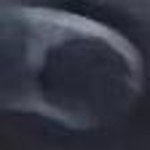

In [8]:
directory = list(data_dir.glob('bolt/*'))
random_image(directory,3)

The image is in ../Dataset/images/bolt/bolt_106.jpg


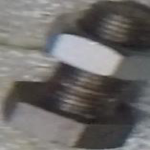

In [9]:
random_image(directory, 10)

The image is in ../Dataset/images/nut/nut_103.jpg


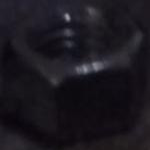

In [10]:
directory = list(data_dir.glob('nut/*'))
random_image(directory, 6)

The image is in ../Dataset/images/flange/flange_10.jpg


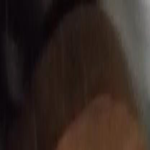

In [11]:
directory = list(data_dir.glob('flange/*'))
random_image(directory, 4)

The image is in ../Dataset/images/pipe/image_111.jpg


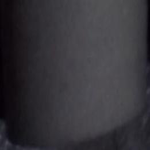

In [12]:
directory = list(data_dir.glob('pipe/*'))
random_image(directory, 15)

In [13]:
# Network Constants
BATCH_SIZE = 32
IMAGE_SIZE = (150, 150)
IMAGE_SHAPE = (150, 150, 3)

# Loading Images using Keras Preprocessing module

In [14]:
# Split the data to training and validation dataset. 
# Use 80% for training and 20% for validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 1755 files belonging to 5 classes.
Using 1404 files for training.


In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 1755 files belonging to 5 classes.
Using 526 files for validation.


In [16]:
# Find the class names
class_names = train_ds.class_names
print(class_names)

['bolt', 'flange', 'lead_block', 'nut', 'pipe']


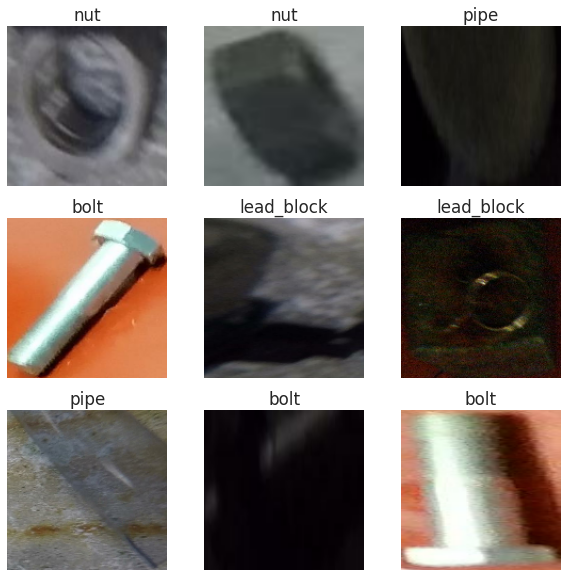

In [17]:
# Visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [18]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 150, 150, 3)
(32,)


# Dataset Configuration

In [19]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice: the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.018297166 0.9061961


In [22]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMAGE_SHAPE),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Because the project is a multi-class, single-label prediction, during the model compilation a categotical
crossentropy is used. Also the selected optimizer is the [Adam](http://arxiv.org/abs/1412.6980) algorithm, since it is an improved vesrsion of the SGD but im more efficient and has less memory conumption and is ideal for problems with lagre number of parameters.


In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

In [25]:
epochs=15
history = model.fit(
                  train_ds,
                  validation_data=val_ds,
                  epochs=epochs)

Epoch 1/15
44/44 [==============================] - 44s 747ms/step - loss: 1.4329 - accuracy: 0.3322 - val_loss: 1.1298 - val_accuracy: 0.4981
Epoch 2/15
44/44 [==============================] - 2s 52ms/step - loss: 1.1832 - accuracy: 0.4793 - val_loss: 1.1817 - val_accuracy: 0.4620
Epoch 3/15
44/44 [==============================] - 3s 53ms/step - loss: 1.0677 - accuracy: 0.5349 - val_loss: 0.9288 - val_accuracy: 0.6065
Epoch 4/15
44/44 [==============================] - 2s 52ms/step - loss: 0.8454 - accuracy: 0.6484 - val_loss: 0.7543 - val_accuracy: 0.7167
Epoch 5/15
44/44 [==============================] - 2s 52ms/step - loss: 0.6957 - accuracy: 0.7212 - val_loss: 0.7393 - val_accuracy: 0.7376
Epoch 6/15
44/44 [==============================] - 2s 51ms/step - loss: 0.5702 - accuracy: 0.7886 - val_loss: 0.7200 - val_accuracy: 0.7662
Epoch 7/15
44/44 [==============================] - 2s 49ms/step - loss: 0.4280 - accuracy: 0.8447 - val_loss: 0.6677 - val_accuracy: 0.7719
Epoch 8/15


In [26]:
def plot(history, epochs):
    
    """
     Display the results of the cnn model.
    args:
        history: the history of the model.fit() method
        epochs (num) : the number of the epochs
    return a plot of the Training and Validation Accuracy
                         Training and Validation Loss.
    """ 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    return plt.show()

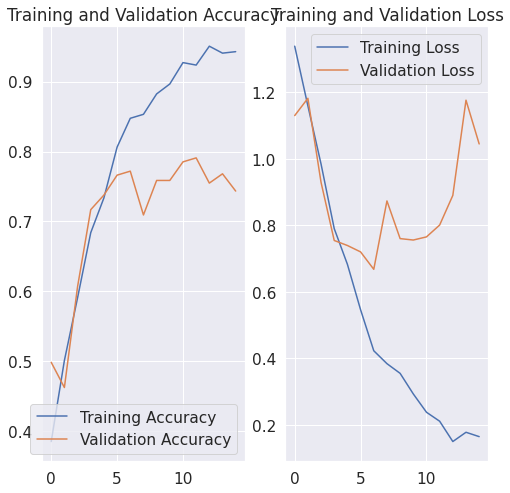

In [27]:
plot(history, epochs)

## Model overfitting

From the abobe plots we can see that the training and validation accuracy are diverging after epoch 5, and the model has achieved a modest validation accuracy of about $68\%$ whilst the training accuracy achieves a score of $96.2\%$.

Thus, the above plots showing clearly that the model is overfitting. Overfitting is mainly because the small number of training data (1403 images for training) which allows the model to learn better the details of an image from the training set which leads to negative results in the overall performance on new examples. The model is unable to generalize the learnt features from the training set and apply them on a new dataset.

# Data Augmentation and Dropout

Since the current dataset is small in size (only 1753 images for 5 differnt classes) one approach to mitigate that issue is to use data augmentation, which will generate aditional training data (using the existing training examples) by applying random transformations on the images.

Another technique to reduce overfitting is to drop some of the last layers of the network out. The Dropout method will randomly drop out a portion of the network's output layers. Normally, the values between $10\% - 50\%$ is used. 

In [28]:
data_augmentation = Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMAGE_SHAPE)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ])

In [29]:
def plot_augment(train_ds):
    plt.figure(figsize=(10, 10))
    for images, _ in train_ds.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[1].numpy().astype("uint8"))
            plt.axis("off")
    
    return plt.show()

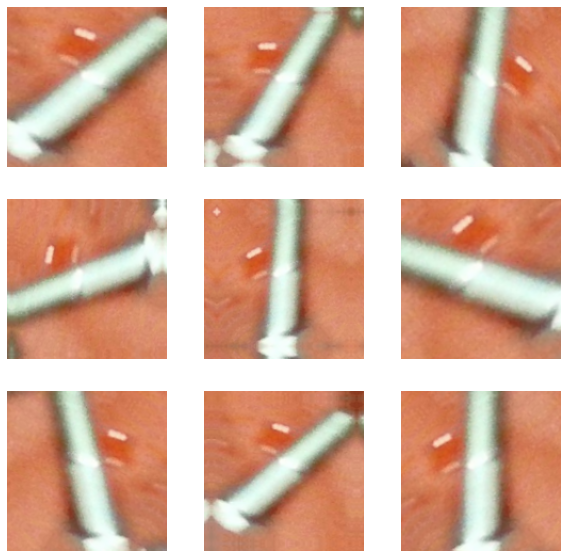

In [30]:
plot_augment(train_ds)

For this model architecture a simple Sequential architectire used mainly because it is a well known an classic starting CNN architecture which includes convulution layers, maxpooling layers, dropout layers as well as using ReLu as an activation function for all layers except the last one which uses a softmax activation since a classification is what need to achieved by the model. 

The steps followed are as follows: 
1. Import the necessary libraries and define a sequential model (at the begining of teh notebook)
2. Add the data_augmentation function
3. dd a two dimensional Convolutional layer followed by a maxpooling layer and in each layer the parameters such as the activation function and the filters were defined as well. The first convolutional layer includes the input shape of the images, and in this architecture is 150 by 150 pixels in 3 RGB scale (depth of the image). 
3. Additionaly, the depth of the Conv-MaxPoll layers is repeated 3 times in total with different filter size begining from 16, 32 and finally 64. 
5. At the end of the last Conv-MaxPoll layer a Flatten layer was used to connect the outputs to the Dense layer. 
6. A Dropout of 20% was used to avoid overfitting which again is connected to a Dense layer. 
7. The last Dense layer has a size of 5 because this is the number of classes that examined in this project and a softmax activation function is used for the classification task. 
8. Finally, a summary of the model is printed to obtain a visualisation of it.

In [31]:
# Using Dropout of .2

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)       

In [34]:
epochs = 15
history = model.fit(
                  train_ds,
                  validation_data=val_ds,
                  epochs=epochs)

Epoch 1/15
44/44 [==============================] - 3s 55ms/step - loss: 1.5494 - accuracy: 0.3409 - val_loss: 1.2796 - val_accuracy: 0.4449
Epoch 2/15
44/44 [==============================] - 2s 51ms/step - loss: 1.2905 - accuracy: 0.4049 - val_loss: 1.1788 - val_accuracy: 0.5266
Epoch 3/15
44/44 [==============================] - 3s 53ms/step - loss: 1.2102 - accuracy: 0.4503 - val_loss: 1.1406 - val_accuracy: 0.4848
Epoch 4/15
44/44 [==============================] - 2s 51ms/step - loss: 1.1915 - accuracy: 0.4430 - val_loss: 1.1275 - val_accuracy: 0.5019
Epoch 5/15
44/44 [==============================] - 3s 53ms/step - loss: 1.1252 - accuracy: 0.4805 - val_loss: 1.0497 - val_accuracy: 0.5342
Epoch 6/15
44/44 [==============================] - 2s 51ms/step - loss: 1.0858 - accuracy: 0.5175 - val_loss: 0.9421 - val_accuracy: 0.6464
Epoch 7/15
44/44 [==============================] - 2s 52ms/step - loss: 0.9857 - accuracy: 0.5817 - val_loss: 0.9906 - val_accuracy: 0.5627
Epoch 8/15
44

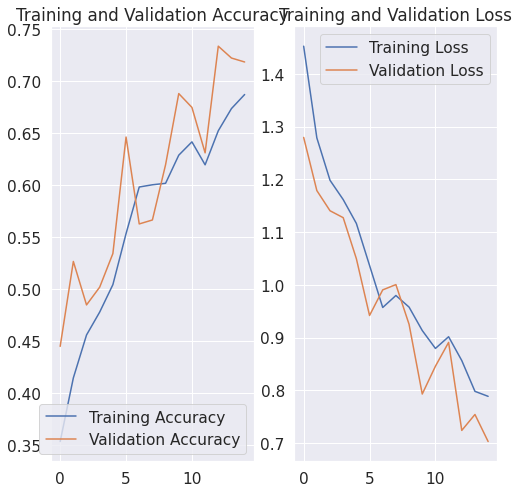

In [35]:
plot(history, epochs)

# Visualize treainin results after data augmentation

After applying data augmentation and the Dropout technique, the overfitting has significantly reduced. The training and validation accuracy as well as the training and validation loss are following the same path in the graph (there is no sign of divergence).

The last step includes testing the model in some random images, images that the model has never seen. The results are quite interested since the model predicts most of the images accuratly, except few cases were gives the wrong result. For example in the image nut.jpg that predicting it as a bolt, in the image 3_image_231.jpg as lead block and the image 1_image_108.jpg as pipe. 
The algorithm needs more data and might need to use trainsfer learning to improve its accuracy.

In [36]:
import tensorflow.keras as keras
#image = [os.path.join(image_path, f) for f in os.listdir(image_path)]

def test_model(image_name, image_path):
    """
    Funtion that tests the model.
    args:
        image_path: the path to the directory with the test images
        image_name: the image name contained in the given directory
    return: the image with the prediction
    """
    
    for image in image_name:
        #print(image)
        path = os.path.join(image_path, image)

        img = keras.preprocessing.image.load_img(
            path, target_size=IMAGE_SIZE
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        plt.imshow(img)
        plt.axis("off")
        plt.show()

        print(
            "The image {} most likely belongs to {} with a {:.2f} percent confidence."
            .format(image, class_names[np.argmax(score)], 100 * np.max(score))
        )
        

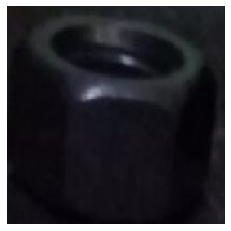

The image 1_image_108.jpg most likely belongs to nut with a 67.25 percent confidence.


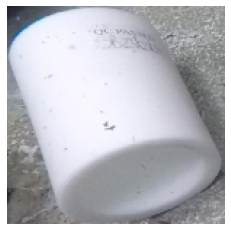

The image 1_image_170.jpg most likely belongs to pipe with a 79.62 percent confidence.


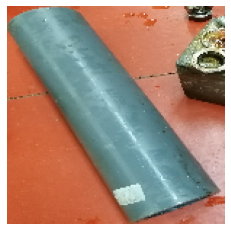

The image 1_image_231.jpg most likely belongs to pipe with a 99.96 percent confidence.


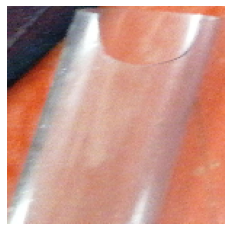

The image 1_image_248.jpg most likely belongs to pipe with a 96.72 percent confidence.


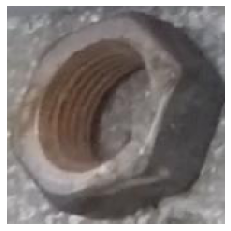

The image 3_image_170.jpg most likely belongs to nut with a 66.19 percent confidence.


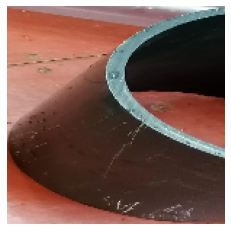

The image 3_image_231.jpg most likely belongs to lead_block with a 73.65 percent confidence.


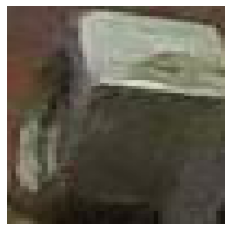

The image 4_image_225.jpg most likely belongs to lead_block with a 50.17 percent confidence.


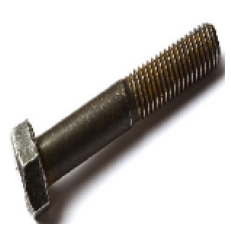

The image bolt_test.png most likely belongs to bolt with a 70.85 percent confidence.


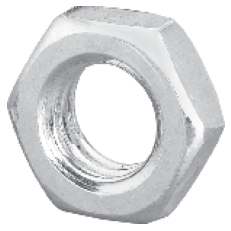

The image hex_nut.png most likely belongs to nut with a 89.49 percent confidence.


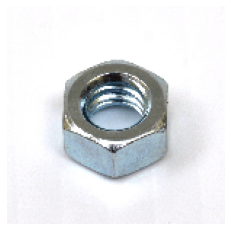

The image nut.jpg most likely belongs to nut with a 71.51 percent confidence.


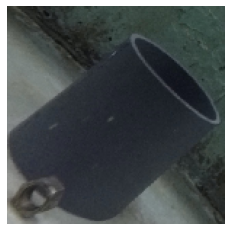

The image pipe.PNG most likely belongs to pipe with a 99.43 percent confidence.


In [37]:
image_path = "../Dataset/test_images/"
image_name = os.listdir(image_path)
test_model(image_name, image_path)

# Create a CNN to Classify images (using Transfer Learning)


In [38]:
from tensorflow.keras.applications import Xception

conv_base = Xception(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)

In [39]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(5, activation='softmax')
])

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 33,970,221
Trainable params: 33,915,693
Non-trainable params: 54,528
_________________________________________________________________


In [41]:
print("Number of trainable weights before freezing the conv base: ", len(model.trainable_weights))
conv_base.trainable = False
print("Number of trainable weights after freezing the conv base: ", len(model.trainable_weights))


Number of trainable weights before freezing the conv base:  158
Number of trainable weights after freezing the conv base:  4


In [42]:
from tensorflow import optimizers

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['accuracy'])

In [43]:
epochs = 30
history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=epochs)

Epoch 1/30
44/44 [==============================] - 62s 982ms/step - loss: 10.5377 - accuracy: 0.3865 - val_loss: 4.8873 - val_accuracy: 0.4639
Epoch 2/30
44/44 [==============================] - 5s 99ms/step - loss: 3.8861 - accuracy: 0.5408 - val_loss: 2.2428 - val_accuracy: 0.6217
Epoch 3/30
44/44 [==============================] - 5s 100ms/step - loss: 2.4821 - accuracy: 0.6215 - val_loss: 1.8976 - val_accuracy: 0.6806
Epoch 4/30
44/44 [==============================] - 5s 100ms/step - loss: 1.6087 - accuracy: 0.7113 - val_loss: 5.1207 - val_accuracy: 0.5703
Epoch 5/30
44/44 [==============================] - 5s 102ms/step - loss: 1.9162 - accuracy: 0.7444 - val_loss: 1.7601 - val_accuracy: 0.7091
Epoch 6/30
44/44 [==============================] - 5s 99ms/step - loss: 1.6047 - accuracy: 0.7665 - val_loss: 1.5604 - val_accuracy: 0.7414
Epoch 7/30
44/44 [==============================] - 5s 102ms/step - loss: 0.9245 - accuracy: 0.8472 - val_loss: 2.1090 - val_accuracy: 0.6825
Epoch 

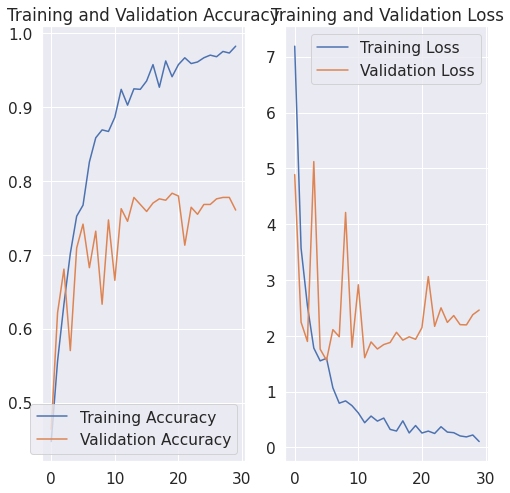

In [44]:
plot(history, epochs)

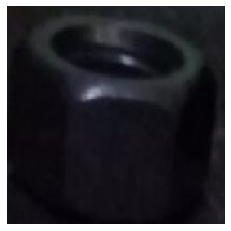

The image 1_image_108.jpg most likely belongs to nut with a 40.46 percent confidence.


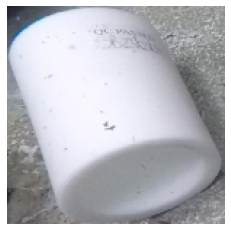

The image 1_image_170.jpg most likely belongs to nut with a 28.40 percent confidence.


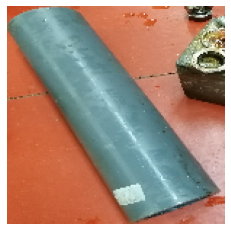

The image 1_image_231.jpg most likely belongs to pipe with a 39.79 percent confidence.


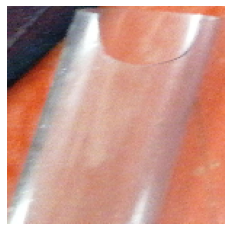

The image 1_image_248.jpg most likely belongs to pipe with a 40.46 percent confidence.


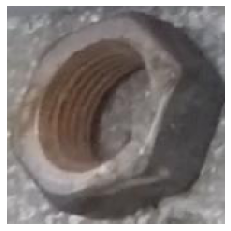

The image 3_image_170.jpg most likely belongs to nut with a 40.46 percent confidence.


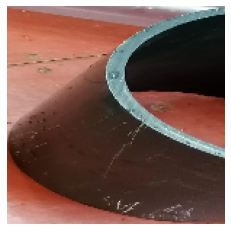

The image 3_image_231.jpg most likely belongs to pipe with a 40.42 percent confidence.


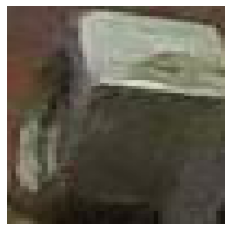

The image 4_image_225.jpg most likely belongs to nut with a 39.46 percent confidence.


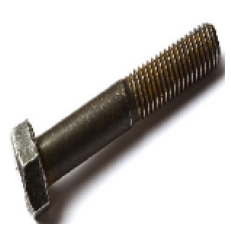

The image bolt_test.png most likely belongs to bolt with a 40.46 percent confidence.


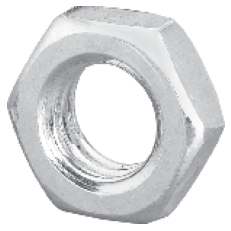

The image hex_nut.png most likely belongs to nut with a 40.07 percent confidence.


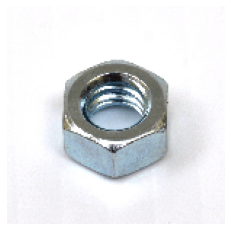

The image nut.jpg most likely belongs to bolt with a 28.69 percent confidence.


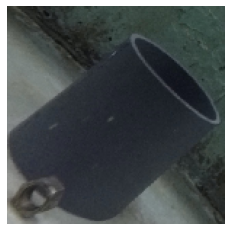

The image pipe.PNG most likely belongs to pipe with a 40.46 percent confidence.


In [45]:
image_path = "../Dataset/test_images/"
image_name = os.listdir(image_path)
test_model(image_name, image_path)

In [46]:
model = models.Sequential([
    data_augmentation,
    conv_base,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(5, activation='softmax')
])

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
epochs = 30
history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=epochs)

Epoch 1/30
44/44 [==============================] - 6s 111ms/step - loss: 1.5976 - accuracy: 0.3564 - val_loss: 1.1784 - val_accuracy: 0.5247
Epoch 2/30
44/44 [==============================] - 5s 100ms/step - loss: 1.1685 - accuracy: 0.5338 - val_loss: 1.1669 - val_accuracy: 0.5418
Epoch 3/30
44/44 [==============================] - 5s 102ms/step - loss: 1.1300 - accuracy: 0.5450 - val_loss: 0.9814 - val_accuracy: 0.6483
Epoch 4/30
44/44 [==============================] - 6s 123ms/step - loss: 1.0243 - accuracy: 0.5866 - val_loss: 0.9762 - val_accuracy: 0.6483
Epoch 5/30
44/44 [==============================] - 5s 105ms/step - loss: 1.0150 - accuracy: 0.5806 - val_loss: 0.9752 - val_accuracy: 0.6692
Epoch 6/30
44/44 [==============================] - 5s 108ms/step - loss: 0.9372 - accuracy: 0.6254 - val_loss: 0.8961 - val_accuracy: 0.6806
Epoch 7/30
44/44 [==============================] - 5s 107ms/step - loss: 0.9500 - accuracy: 0.6337 - val_loss: 1.0550 - val_accuracy: 0.5894
Epoch 

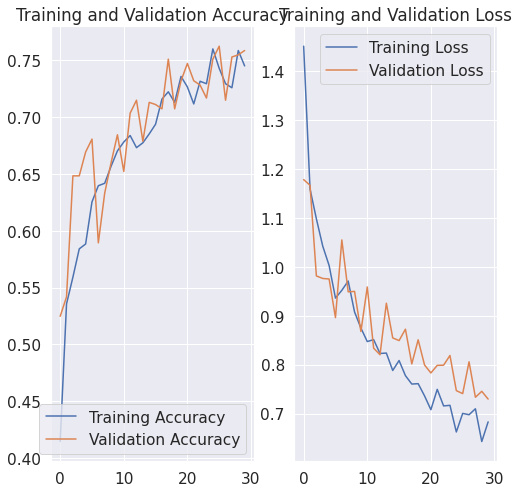

In [49]:
plot(history, epochs)

By training the model, it can be seen that the training accuracy is steadily increased and after 30 epochs is 0.9451 wherein contrast the validation accuracy follows for about 10 epochs the training accuracy and after it reaches a plateau at 0.75. The above plots are showing the results after the training period and is an indication of overfiting. The overfitting is moslty due to small amount of the images in the dataset. In the above transfer learning model, the *Xception* model was used. To conduct corectly the pre-trained model need to use *feature extraction* and *fine-tuning*.

Feature extraction is when we use the representations learned by the network previously, which has learnt to extract useful features from new samples. Then, this features will run through the new classifier for training from scratch. If the new dataset has large differnce from the dataset tha the original networks has trained, it is better to use only the few first layers of the model to do the feature extraction, rather than using the entire convolutional base. In the above Xception model, the Densly-conected layer was not included, since I only need 5 classes ('bolt', 'flange', 'lead_block', 'nut', 'pipe'), instead of the 1000 classes of the imagenet. The input shape for the *Xception* model is 150x150x3 tensor, and if the input size will not be specified, the network will be able to process any size.

Since the pre-trained model was not performed as expected need to run it again and perform changes to the final model, change the optimizer to *Adam*?  

```python
model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['accuracy'])
```

Also, in the next atempt when using the data_augmentation, a warning was appeared (```WARNING:tensorflow:Model was constructed with shape (None, 150, 150, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='random_flip_input'), name='random_flip_input', description="created by layer 'random_flip_input'"), but it was called on an input with incompatible shape (None, 5, 5, 2048```). So, might need to use data_augmentation at the begining of the model, before the conv_base.

```python
model = models.Sequential([
    conv_base,
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(5, activation='softmax')
])
```

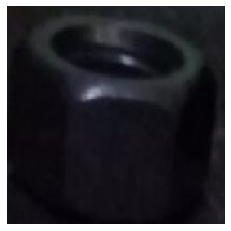

The image 1_image_108.jpg most likely belongs to bolt with a 27.84 percent confidence.


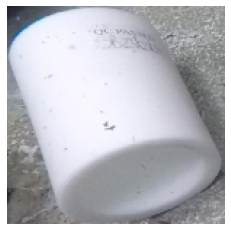

The image 1_image_170.jpg most likely belongs to pipe with a 40.06 percent confidence.


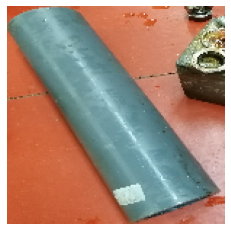

The image 1_image_231.jpg most likely belongs to pipe with a 39.75 percent confidence.


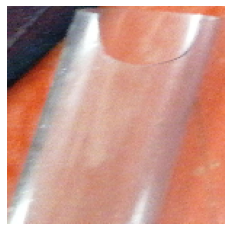

The image 1_image_248.jpg most likely belongs to pipe with a 40.46 percent confidence.


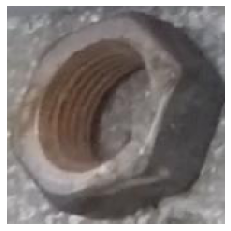

The image 3_image_170.jpg most likely belongs to lead_block with a 37.34 percent confidence.


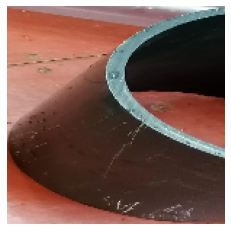

The image 3_image_231.jpg most likely belongs to pipe with a 39.49 percent confidence.


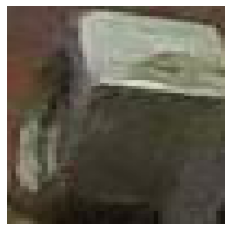

The image 4_image_225.jpg most likely belongs to pipe with a 24.05 percent confidence.


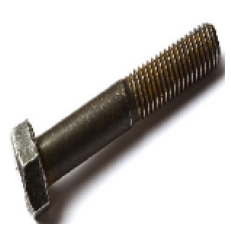

The image bolt_test.png most likely belongs to nut with a 28.38 percent confidence.


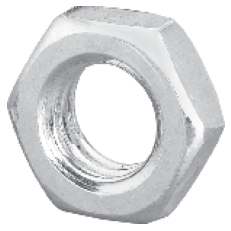

The image hex_nut.png most likely belongs to bolt with a 29.50 percent confidence.


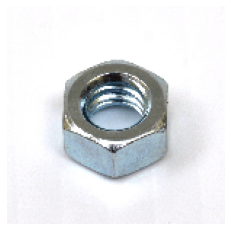

The image nut.jpg most likely belongs to bolt with a 37.69 percent confidence.


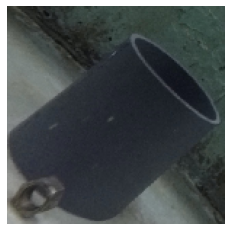

The image pipe.PNG most likely belongs to pipe with a 28.62 percent confidence.


In [50]:
image_path = "../Dataset/test_images/"
image_name = os.listdir(image_path)
test_model(image_name, image_path)

In [51]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________